In [1]:
using NBInclude
using LinearAlgebra

@nbinclude("julia_function.ipynb")

allskyevents_free_eres (generic function with 1 method)

In [66]:
# Event distribution calculation functions

# Approximate binned perfect event distribution
function perfectedistapprox(dm2, l, b, θ, nsteps)
    
    function f(u)
        et = 10 ^ u
        rbins = range(0, 30, nsteps)
        dr = rbins[2] - rbins[1]

        vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)

        flux = flx(et) .* probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b)) * 3
        effa = effarea(et)*10000

        sum(.*(flux, vols, effa))
    end

    # du = (log10(emax) - log10(emin)) / nsteps
    us = range(log10(emin), log10(emax), nsteps)

    du = us[2] - us[1]

    output = f.(us) .* du .* (10 .^ us) .* log(10)
end

# Fully integrated perfect event distribution
function perfectedist(dm2, l, b, θ, nbins)
    
    function f(u, dm2, l, b)
        et = 10 ^ u
        rbins = range(0, 30, 61)
        dr = rbins[2] - rbins[1]

        vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)

        flux = flxpdf(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b)) * 1.35911
        effa = effarea(et)*10000

        sum(.*(flux, vols, effa))
    end

    nsteps = 1000

    stepsperbin = convert(Int, nsteps/nbins)

    us = range(log10(emin), log10(emax), nsteps)
    du = us[2] - us[1]
    steps = f.(us, dm2, l, b) .* du .* (10 .^ us) .* log(10)

    mat = reshape(steps, (stepsperbin, :))

    sums = sum(mat, dims=1)
    νbins = vec(sums)
end

function testpdf_gc(r, μ, σ)
    return pdf(Normal(μ, σ), r)
end

function testpdf_gc_2gauss(r, μ₁, σ₁, μ₂, σ₂)
    return 0.5 * (pdf(Normal(μ₁, σ₁), r) + pdf(Normal(μ₂, σ₂), r))
end

# Pos is [r, z], Params is [μr, μz, σr, σz]
function test_pdf_3dgauss(pos, params)
    rnorm = pdf(Normal(params[1], params[3]), pos[1])
    znorm = pdf(Normal(params[2], params[4]), pos[2])
    return rnorm*znorm
end

function perfectedist_testpdf(dm2, l, b, θ, nbins, μ, σ)
    
    function f(u)
        et = 10 ^ u
        rbins = range(0, 30, 60)
        dr = rbins[2] - rbins[1]

        vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)

        flux = flx(et) .* testpdf_gc.(rbins, μ, σ) * 1.35911
        effa = effarea(et)*10000

        sum(.*(flux, vols, effa))
    end

    nsteps = 1000

    stepsperbin = convert(Int, nsteps/nbins)

    us = range(log10(emin), log10(emax), nsteps)
    du = us[2] - us[1]
    steps = f.(us) .* du .* (10 .^ us) .* log(10)

    mat = reshape(steps, (stepsperbin, :))

    sums = sum(mat, dims=1)
    νbins = vec(sums)
end

function perfectedist_testpdf_2gauss(dm2, l, b, θ, nbins, μ₁, σ₁, μ₂, σ₂)
    
    function f(u)
        et = 10 ^ u
        rbins = range(0, 30, 60)
        dr = rbins[2] - rbins[1]

        vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)

        flux = flx(et) .* testpdf_gc_2gauss.(rbins, μ₁, σ₁, μ₂, σ₂) * 1.35911
        effa = effarea(et)*10000

        sum(.*(flux, vols, effa))
    end

    nsteps = 1000

    stepsperbin = convert(Int, nsteps/nbins)

    us = range(log10(emin), log10(emax), nsteps)
    du = us[2] - us[1]
    steps = f.(us) .* du .* (10 .^ us) .* log(10)

    mat = reshape(steps, (stepsperbin, :))

    sums = sum(mat, dims=1)
    νbins = vec(sums)
end

function perfectedist_testpdf_3dgauss_old(dm2, l, b, θ, nbins, params)
    
    function f(u)
        et = 10 ^ u
        rbins = range(0, 30, 60)
        dr = rbins[2] - rbins[1]
        rbinsproj = rbins * cos(b)
        rbinstrue = @. sqrt(rbinsproj^2 + 64 - 16*rbinsproj*cos(l))
        zs = rbins * sin(b)

        vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)
        flux = zeros(60)
        for bin in 1:length(flux)
            flux[bin] = flx(et) * test_pdf_3dgauss([rbinstrue[bin], zs[bin]], params) * 1.35911
        end
        effa = effarea(et)*10000

        sum(.*(flux, vols, effa))
    end

    nsteps = 1000

    stepsperbin = convert(Int, nsteps/nbins)

    us = range(log10(emin), log10(emax), nsteps)
    du = us[2] - us[1]
    steps = f.(us) .* du .* (10 .^ us) .* log(10)

    mat = reshape(steps, (stepsperbin, :))

    sums = sum(mat, dims=1)
    νbins = vec(sums)
end

function perfectedist_testpdf_3dgauss(dm2, l, b, θ, nbins, params)
    
    function f!(dm2, emptyvec, us, l, b, θ, params)
        us .= 10 .^ us
        rbins = range(0, 30, 60)
        dr = rbins[2] - rbins[1]
        rbinsproj = rbins * cos(b)
        rbinstrue = @. sqrt(rbinsproj^2 + 64 - 16*rbinsproj*cos(l))
        zs = rbins * sin(b)
        # emptyvec .= dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)
        # flux = zeros(60)
        for i in 1:length(us)
            for j in 1:length(rbins)
                pos = @SVector [rbinstrue[j], zs[j]]
                emptyvec[i][j] = flx(us[i]) * test_pdf_3dgauss(pos, params) * 1.35911 * dr * sbinarea((rbins[j] + dr), l, b, θ) * oscprob(us[i], dm2, rbins[j]) * 10000
            end
        end
        # emptyvec .= map(x -> x * effarea.(us), emptyvec)
        emptyvec .= [inner .* scalar for (inner, scalar) in zip(emptyvec, effarea.(us))]
        # effa = effarea(et)*10000
    
        map(sum, emptyvec)
    end

    nsteps = 500

    stepsperbin = convert(Int, nsteps/nbins)

    us = collect(range(log10(emin), log10(emax), nsteps))
    us1 = collect(range(log10(emin), log10(emax), nsteps))
    du = us[2] - us[1]

    emptyvec = [zeros(60) for _ in 1:nsteps]
    steps = du .* (10 .^ us) .* log(10) .* f!(dm2, emptyvec, us1, l, b, θ, params)

    mat = reshape(steps, (stepsperbin, :))

    sums = sum(mat, dims=1)
    νbins = vec(sums)
end

perfectedist_testpdf_3dgauss (generic function with 1 method)

In [355]:
dm2 = 0; l = 0; b = 0; θ = 0.122

function f!(dm2, emptyvec, us, l, b, θ, params)
    us .= 10 .^ us
    rbins = range(0, 30, 60)
    dr = rbins[2] - rbins[1]
    rbinsproj = rbins * cos(b)
    rbinstrue = @. sqrt(rbinsproj^2 + 64 - 16*rbinsproj*cos(l))
    zs = rbins * sin(b)
    # emptyvec .= dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)
    # flux = zeros(60)
    for i in 1:length(us)
        for j in 1:length(rbins)
            pos = @SVector [rbinstrue[j], zs[j]]
            emptyvec[i][j] = flx(us[i]) * test_pdf_3dgauss(pos, params) * 1.35911 * dr * sbinarea((rbins[j] + dr), l, b, θ) * oscprob(us[i], dm2, rbins[j]) * 10000
        end
    end
    # emptyvec .= map(x -> x * effarea.(us), emptyvec)
    emptyvec .= [inner .* scalar for (inner, scalar) in zip(emptyvec, effarea.(us))]
    # effa = effarea(et)*10000

    map(sum, emptyvec)
end

f! (generic function with 3 methods)

In [364]:
evec = collect(range(log10(emin), log10(emax), 1000))
params = [1, 1, 1, 1]
emptyvec = [zeros(60) for _ in 1:length(evec)]
@time f!(0, emptyvec, evec, 0, 0, 0.122, params)

  0.015257 seconds (1.01 k allocations: 555.750 KiB)


1000-element Vector{Float64}:
 46.41679274834976
 48.201010518555975
 49.91688293032098
 51.566163047749924
 53.150564451317344
 54.67176207524345
 56.131393027670626
 57.53105739398732
 58.87231902363866
 60.15670630075767
 61.38571289894313
 62.560798520504335
 63.68338962048619
  ⋮
  0.001217059295989676
  0.0011951098133875535
  0.0011735669568569234
  0.001152423048424099
  0.0011316705569925567
  0.001111302095508802
  0.001091310418183191
  0.0010716884177647198
  0.001052429122868668
  0.001033525695356096
  0.0010149714277641873
  0.0009967597407864151

In [274]:
@btime perfectedist_testpdf_3dgauss(0, 0, 0, 0.122, 100, [1, 1, 1, 1])

  36.828 ms (93200 allocations: 7.84 MiB)


100-element Vector{Float64}:
 2.9535696463595587
 3.908786444914224
 4.531537061920841
 4.92549395058522
 5.227006271829145
 5.532479039811597
 5.833924295729886
 6.052526216442349
 6.301787660634255
 6.606511734189442
 6.824114018785025
 6.989733616479084
 7.154007221800153
 ⋮
 0.2221001268949197
 0.20461813056176137
 0.18844041256722865
 0.1707047764620807
 0.1540754221684694
 0.13946924091845905
 0.12966219743742627
 0.12167218613108408
 0.11425805715310354
 0.10500099957764653
 0.09411162418758144
 0.08442754290514587

In [383]:
@btime perfectedist_testpdf_3dgauss(0, 0, 0, 0.122, 100, [1, 1, 1, 1])

  3.043 ms (1039 allocations: 562.09 KiB)


100-element Vector{Float64}:
 2.9041880475527098
 3.872005127587545
 4.51488021307613
 4.914328494155499
 5.22039727547265
 5.522537880213738
 5.828537451911702
 6.050879614834821
 6.293897925710045
 6.602628211776104
 6.823927874608565
 6.989995609635638
 7.1562104405487
 ⋮
 0.22161315694110695
 0.2041632163544066
 0.18794332874639086
 0.17014294034710148
 0.15355991938444158
 0.1390655209088034
 0.12942173825490794
 0.12144292664744033
 0.11403934831713139
 0.10455625698035412
 0.09370672224007587
 0.0840589773396129

In [180]:
params = [4, 0, 2, 2]

nxs, nys, nzs = 100, 100, 100
xs = range(-20, 20, nxs)
ys = range(-20, 20, nys)
zs = range(-5, 5, nzs)
valstopview = zeros(nxs, nys)
valssideview = zeros(nzs, nxs)

for (i, x) in enumerate(xs)
    for (j, y) in enumerate(ys)
        r = sqrt(x^2 + y^2)
        valstopview[i, j] = test_pdf_3dgauss([r, 0], params)
    end
end

In [181]:
for (i, x) in enumerate(xs)
    for (j, z) in enumerate(zs)
        r = abs(x)
        valssideview[j, i] = test_pdf_3dgauss([r, z], params)
    end
end


In [81]:
l = 0; b = 0; θ = 0.122; dm2 = 0

function f(us, nsteps)
    et = 10 ^ u
    rbins = range(0, 30, nsteps)
    dr = rbins[2] - rbins[1]

    vols = dr .* sbinarea.((rbins .+ dr), l, b, θ) .* oscprob.(et, dm2, rbins)

    flux = flxpdf(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b)) * 1.35911
    effa = effarea(et)*10000

    sum(.*(flux, vols, effa))
end

f (generic function with 1 method)

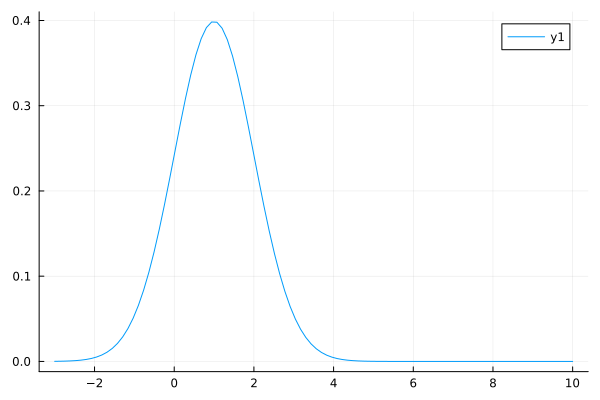

In [6]:
func(x) = pdf(Normal(1, 1), x)

samples = range(-3, 10, 100)

plot(
    range(-3, 10, 100),
    func.(samples)
)

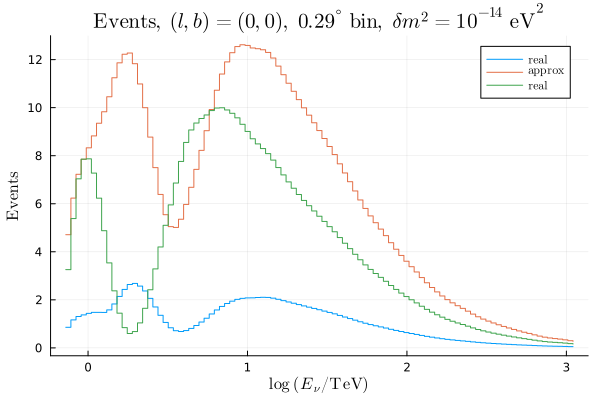

In [109]:
# Plotting approximate vs true perfect event distributions

ebinnum = 100
dm2 = 10^(-14)

ebins = range(log10(emin), log10(emax), ebinnum)

realdist = perfectedist(dm2, 0, 0, 0.122, ebinnum)
testdist = perfectedist_testpdf(dm2, 0, 0, 0.122, ebinnum, 8, 5)
testdist2 = perfectedist_testpdf(dm2, 0, 0, 0.122, ebinnum, 7, 1)

plot(
    ebins,
    [realdist testdist testdist2],
    seriestype=:step,
    title=L"\mathrm{Events},~(l, b) = (0, 0),~0.29^{\circ}~\mathrm{bin},~\delta m^2 = 10^{-14}~\mathrm{eV}^2",
    label=[L"\mathrm{real}" L"\mathrm{approx}"],
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}"
)

In [67]:
function poissonlog_gc(data, hyp)
    # Avoiding weird /0 scenarios
    if hyp < 1e-20
        hyp = 1e-20
    end
    val = log((hyp^data) * exp(-hyp) / gamma(data+1))
end

function negloglh_gc(dm2, l, b, θ, numbins, μ, σ)

    nullhyp = perfectedist(dm2, l, b, θ, numbins)
    althyp = perfectedist_testpdf(dm2, l, b, θ, numbins, μ, σ)

    altsummand = poissonlog_gc.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end

function maxlh_gc(dm2, l, b, θ, numbins)

    # test is [μ, σ]
    function nllh(test)
        return negloglh_gc(dm2, l, b, θ, numbins, test[1], test[2])
    end

    x0 = [8.0, 1.0]

    optimize(nllh, x0, NelderMead())
end

function lrt_gc(null, alt)
    altsummand = sum(poissonlog_gc.(null, alt) .- poissonlog_gc.(null, null))
    ts = -2 * altsummand
end

function negloglh_gc_2gauss(dm2, l, b, θ, numbins, μ₁, σ₁, μ₂, σ₂)

    nullhyp = perfectedist(dm2, l, b, θ, numbins)
    althyp = perfectedist_testpdf_2gauss(dm2, l, b, θ, numbins, μ₁, σ₁, μ₂, σ₂)

    altsummand = poissonlog_gc.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end

function maxlh_gc_2gauss(dm2, l, b, θ, numbins)

    # test is [μ, σ]
    function nllh(test)
        return negloglh_gc_2gauss(dm2, l, b, θ, numbins, test[1], test[2], test[3], test[4])
    end

    x0 = [8.0, 1.0, 8.0, 1.0]

    lower = [0.0, 0.0, 0.0, 0.0]
    upper = [20.0, Inf, 20.0, Inf]
    inner_optimizer = LBFGS()
    optimize(nllh, lower, upper, x0, Fminbox(inner_optimizer))
    # optimize(nllh, x0, NelderMead())
end

function negloglh_gc_3dgauss(dm2, l, b, θ, numbins, params)

    nullhyp = perfectedist(dm2, l, b, θ, numbins)
    althyp = perfectedist_testpdf_3dgauss(dm2, l, b, θ, numbins, params)

    altsummand = poissonlog_gc.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end

function maxlh_gc_3dgauss(dm2, l, b, θ, numbins)

    # test is [μ, σ]
    function nllh(test)
        return negloglh_gc_3dgauss(dm2, l, b, θ, numbins, test)
    end

    x0 = [8.0, 0.0, 1.0, 1.0]

    lower = [0.0, -3.0, 0.0, 0.0]
    upper = [20.0, 3.0, Inf, Inf]
    inner_optimizer = LBFGS()
    optimize(nllh, lower, upper, x0, Fminbox(inner_optimizer))
    # optimize(nllh, x0, NelderMead())
end

function maxlh_moresky_3dgauss(dm2, θ, numbins)

    # test is [μ, σ]
    function nllh(test)
        gc = negloglh_gc_3dgauss(dm2, 0, 0, θ, numbins, test)
        antigc = negloglh_gc_3dgauss(dm2, π, 0, θ, numbins, test)
        above = negloglh_gc_3dgauss(dm2, 0, π/8, θ, numbins, test)
        below = negloglh_gc_3dgauss(dm2, 0, -π/8, θ, numbins, test)
        return gc+antigc+above+below
    end

    x0 = [8.0, 0.0, 1.0, 1.0]

    lower = [0.0, -3.0, 0.0, 0.0]
    upper = [20.0, 3.0, Inf, Inf]
    inner_optimizer = LBFGS()
    optimize(nllh, lower, upper, x0, Fminbox(inner_optimizer))
    # optimize(nllh, x0, NelderMead())
end

maxlh_moresky_3dgauss (generic function with 1 method)

In [144]:
# Exponential with a central hole

function expdisk(r, nd, r0, rh, hi)
    return nd * exp(-(r - 8)/r0) * (1 - exp(-(r/rh)^hi))
end

nd = 0.894
r0 = 1.27
rh = 6.34
hi = 6.38

nxs, nys = 500, 500
xs = range(-20, 20, nxs)
ys = range(-20, 20, nys)
vals = zeros(nxs, nys)

for (i, x) in enumerate(xs)
    for (j, y) in enumerate(ys)
        r = sqrt(x^2 + y^2)
        vals[i, j] = expdisk(r, nd, r0, rh, hi)
    end
end


In [124]:
hegloglh_gc_3dgauss(10^(-14), 0, π/2, )

 99.904108 seconds (64.22 M allocations: 7.402 GiB, 3.65% gc time, 2.22% compilation time: 4% of which was recompilation)


 * Status: success

 * Candidate solution
    Final objective value:     9.954264e+01

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 6.30e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.44e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   99  (vs limit Inf)
    Iterations:    4
    f(x) calls:    96
    ∇f(x) calls:   96


In [385]:
ebinnum = 100
dm2 = 10^(-13.5)
optimized = maxlh_moresky_3dgauss(dm2, 0.122, ebinnum)
optim_params = Optim.minimizer(optimized)

ebins = range(log10(emin), log10(emax), ebinnum)

realdist = perfectedist(dm2, 0, 0, 0.122, ebinnum)
# testdist = perfectedist_testpdf(dm2, 0, 0, 0.122, ebinnum, 8, 5)
# testdist2 = perfectedist_testpdf(dm2, 0, 0, 0.122, ebinnum, 7, 1)
optimdist = perfectedist_testpdf_3dgauss(dm2, 0, 0, 0.122, ebinnum, optim_params)

LoadError: InterruptException:

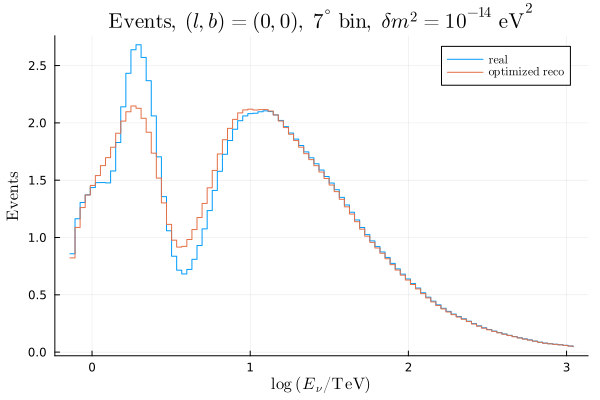

In [264]:
plot(
    ebins,
    [realdist optimdist],
    seriestype=:step,
    title=L"\mathrm{Events},~(l, b) = (0, 0),~7^{\circ}~\mathrm{bin},~\delta m^2 = 10^{-14}~\mathrm{eV}^2",
    label=[L"\mathrm{real}" L"\mathrm{optimized~reco}"],
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}"
)

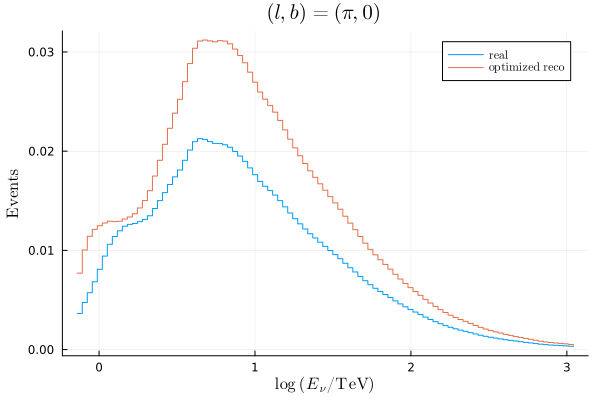

In [273]:
realdist_anticenter = perfectedist(dm2, π, 0, 0.122, ebinnum)
optimdist_anticenter = perfectedist_testpdf_3dgauss(dm2, π, 0, 0.122, ebinnum, optim_params)

plot(
    ebins,
    [realdist_anticenter optimdist_anticenter],
    seriestype=:step,
    title=L"(l, b) = (\pi, 0)",
    label=[L"\mathrm{real}" L"\mathrm{optimized~reco}"],
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}"
)

In [65]:
# [μr, μz, σr, σz]
optim_params_14 = [ 7.427936956513634e-9
0.19847963019158368
5.537657261819168
0.07538996680247223]

4-element Vector{Float64}:
 7.427936956513634e-9
 0.19847963019158368
 5.537657261819168
 0.07538996680247223

In [68]:
function nllh_test(dm2, θ, numbins, test)
    gc = negloglh_gc_3dgauss(dm2, 0, 0, θ, numbins, test)
    antigc = negloglh_gc_3dgauss(dm2, π, 0, θ, numbins, test)
    above = negloglh_gc_3dgauss(dm2, 0, π/8, θ, numbins, test)
    below = negloglh_gc_3dgauss(dm2, 0, -π/8, θ, numbins, test)
    return gc+antigc+above+below
end

nllh_test (generic function with 1 method)

In [69]:
negloglh_14 = nllh_test(10^(-13.5), 0.122, 100, optim_params_14)

93.29304942825576

In [70]:
ebinnum = 100
dm2 = 0
optimized = maxlh_moresky_3dgauss(dm2, 0.122, ebinnum)
optim_params = Optim.minimizer(optimized)

ebins = range(log10(emin), log10(emax), ebinnum)

realdist = perfectedist(dm2, 0, 0, 0.122, ebinnum)
# testdist = perfectedist_testpdf(dm2, 0, 0, 0.122, ebinnum, 8, 5)
# testdist2 = perfectedist_testpdf(dm2, 0, 0, 0.122, ebinnum, 7, 1)
optimdist = perfectedist_testpdf_3dgauss(dm2, 0, 0, 0.122, ebinnum, optim_params)

LoadError: InterruptException:

In [268]:
nxs, nys, nzs = 200, 200, 200
xs = range(-20, 20, nxs)
ys = range(-20, 20, nys)
zs = range(-10, 10, nzs)
valstopview = zeros(nxs, nys)
valssideview = zeros(nzs, nxs)

for (i, x) in enumerate(xs)
    for (j, y) in enumerate(ys)
        r = sqrt(x^2 + y^2)
        valstopview[i, j] = test_pdf_3dgauss([r, 0], optim_params)
    end
end

for (i, x) in enumerate(xs)
    for (j, z) in enumerate(zs)
        r = abs(x)
        valssideview[j, i] = test_pdf_3dgauss([r, z], optim_params)
    end
end

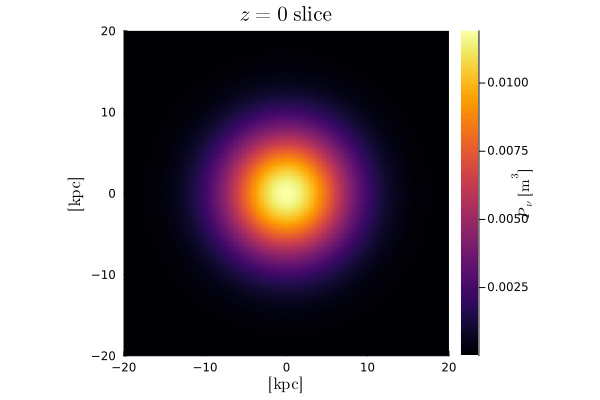

In [269]:
heatmap(
    xs,
    ys,
    valstopview,
    xlabel=L"[\mathrm{kpc}]",
    ylabel=L"[\mathrm{kpc}]",
    title=L"z=0~\mathrm{slice}",
    colorbar_title=L"P_{\nu}~[\mathrm{m}^3]",
    xlims=(-20, 20),
    ylims=(-20, 20),
    aspect_ratio=:1,
)

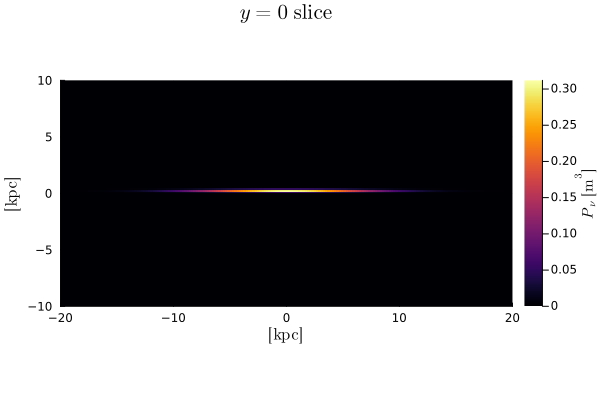

In [270]:
heatmap(
    xs,
    zs,
    valssideview,
    xlabel=L"[\mathrm{kpc}]",
    ylabel=L"[\mathrm{kpc}]",
    title=L"y=0~\mathrm{slice}",
    colorbar_title=L"P_{\nu}~[\mathrm{m}^3]",
    xlims=(-20, 20),
    ylims=(-10, 10),
    aspect_ratio=:1,
)

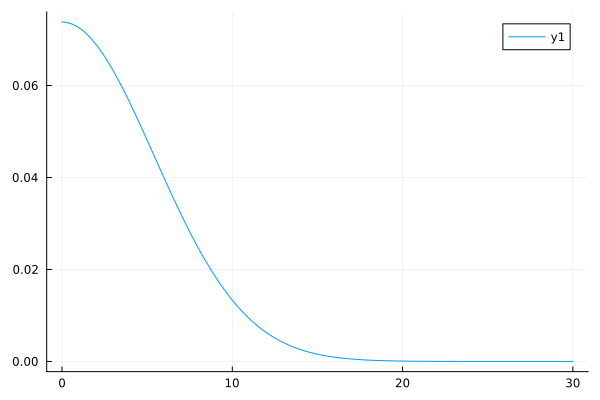

In [127]:
rs = range(0, 30, 100)
plot(
    rs,
    testpdf_gc_2gauss.(rs, optim_params[1], optim_params[2], optim_params[3], optim_params[4])
)

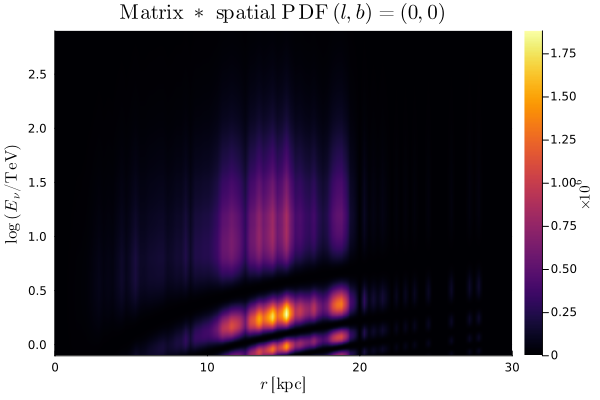

In [9]:
# Plotting the full matrix

nbins = 1000
dm2 = 10^(-14)

us = range(log10(emin), log10(emax), nbins)

rs = range(0, 30, nbins)

A = matrixA(dm2, 0, 0, nbins)

for j in 1:nbins
    for i in 1:nbins
        A[i, j] *= probdens(cartx(rs[j], 0, 0), carty(rs[j], 0, 0), cartz(rs[j], 0, 0))
    end
end

heatmap(
    rs,
    us,
    A .* 1000000,
    title=L"\mathrm{Matrix}~*~\mathrm{spatial~PDF}~(l, b) = (0, 0)",
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    colorbar_title=L"\times 10^6"
)

In [46]:
# Matrix construction functions

# Constants dependent on energy
function c(u, du, dr)
    e = 10^u
    effarea(e) * 10000 * flx(e) * du * dr * 10^u * log(10) * 3
end

# Oscillation and bin volume
function o(dm2, u, r, dr, l, b, θ)
    e = 10^u
    oscprob(e, dm2, r) * sbinarea.((r+dr), l, b, θ)
end

# Pure oscillation matrix (just the cosine dependent terms)
function matrixOsc(dm2, bins)

    us = range(log10(emin), log10(emax), bins)
    es = 10 .^ us
    rs = range(0, 30, bins)
    # dr = rs[2] - rs[1]

    O = [oscprob(e, dm2, r) for e in es, r in rs]
end

# let bins be an even number
function subOscmats(dm2, bins)

    us = range(log10(emin), log10(emax), bins)
    es = 10 .^ us
    rs = range(0, 30, bins)

    O = [oscprob(e, dm2, r) for e in es, r in rs]

    # Calculate the midpoint (used for splitting)
    mid = div(bins, 2)

    # Extract submatrices
    bottom_left = O[1:mid, 1:mid]
    bottom_right = O[1:mid, mid+1:end]
    top_right = O[mid+1:end, 1:mid]
    top_left = O[mid+1:end, mid+1:end]

    return [top_left, top_right, bottom_right, bottom_left]

end


# Full matrix with energy and bin size terms
function matrixA(dm2, l, b, bins)  

    us = range(log10(emin), log10(emax), bins)

    rs = range(0, 30, bins)

    du = us[2] - us[1]
    dr = rs[2] - rs[1]

    A = [c(u, du, dr)*o(dm2, u, r, dr, l, b, 0.005) for u in us, r in rs]

end

# Pure oscillation matrix with energy bounds left free
function matrixOsc1(dm2, bins, umin, umax)

    us = range(umin, umax, bins)
    es = 10 .^ us
    rs = range(0, 30, bins)

    O = [oscprob(e, dm2, r) for e in es, r in rs]
end

# ONLY the cosine terms, no PMNS matrix vals
function justosc(dm2, bins)

    function cososc(dm2, e, r)
        convfactor = 3.086e19 * 5.06773093741 * 1e6
        r *= convfactor
        osc = (cos((dm2 * r)/(4*e*1e12)))^2
    end

    us = range(log10(emin), log10(emax), bins)
    es = 10 .^ us
    rs = range(0, 30, bins)
    dr = rs[2] - rs[1]

    justO = [cososc(dm2, e, r+dr) for e in es, r in rs]

end

# Matrix manipulation functions

# Absolute value of the determinant of the oscillation matrix
function Odet(dm2, bins)
    d = abs(det(matrixOsc(dm2, bins)))
end

function subOdets(dm2, bins)
    submats = subOscmats(dm2, bins)
    return [abs(det(submats[1])), abs(det(submats[2])), abs(det(submats[3])), abs(det(submats[4]))]
end


function Adet(dm2, l, b, bins)
    d = abs(det(matrixA(dm2, l, b, bins)))
end

function Osc1det(dm2, bins, umin, umax)
    d = abs(det(matrixOsc1(dm2, bins, umin, umax)))
end

function justoscdet(dm2, bins)
    d = abs(det(justosc(dm2, bins)))
end

justoscdet (generic function with 1 method)

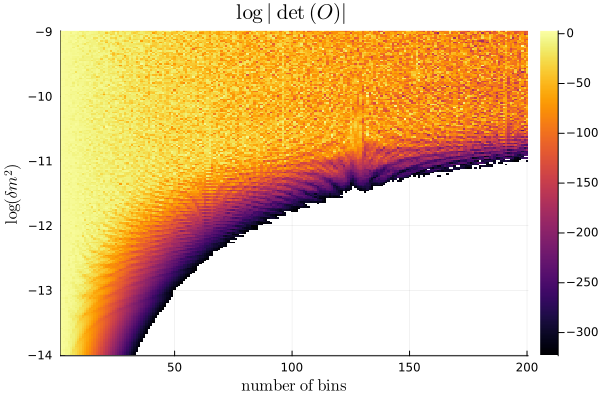

In [53]:
# Plotting the matrix determinant

binss = 2:1:200

logdm2s = range(-14.0, -9.0, length=200)
dm2s = 10 .^ logdm2s

detOmat = [Odet(dm2, bins) for dm2 in dm2s, bins in binss]

heatmap(
    binss,
    logdm2s,
    log10.(detOmat),
    title=L"\log~|\det~(O)|",
    xlabel=L"\mathrm{number~of~bins}",
    ylabel=L"\log (\delta m^2)",
    color=:inferno
)

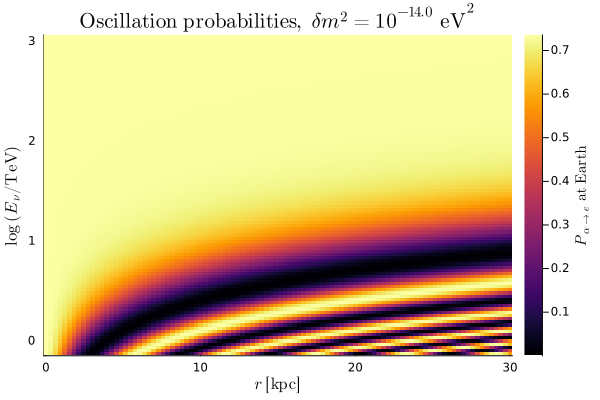

In [47]:
# Plotting the oscillation probabilities

dim = 100

us = range(log10(emin), log10(emax), dim)
rs = range(0, 30, dim)

O = matrixOsc(10^(-14), dim)

heatmap(
    rs,
    us,
    O,
    title=L"\mathrm{Oscillation~probabilities},~\delta m^2 = 10^{-14.0}~\mathrm{eV}^2",
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    colorbar_title=L"P_{\alpha \to e}~\mathrm{at~Earth}"
)

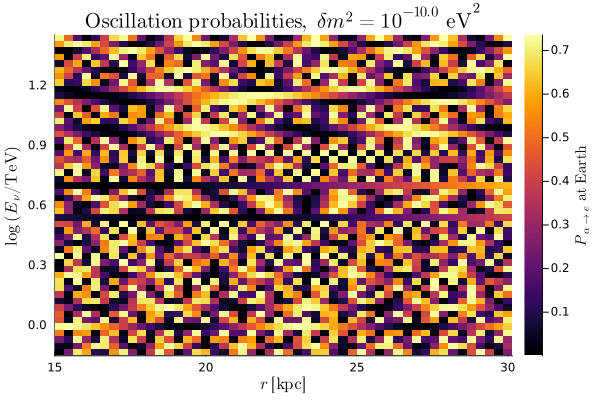

attempt to save state beyond implementation limit


In [63]:
dim = 100

dimover2 = div(dim, 2)

us = range(log10(emin), log10(emax), dim)
rs = range(0, 30, dim)

O = subOscmats(10^(-10), dim)[3]

heatmap(
    rs[dimover2+1:end],
    us[1:dimover2],
    O,
    title=L"\mathrm{Oscillation~probabilities},~\delta m^2 = 10^{-10.0}~\mathrm{eV}^2",
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    colorbar_title=L"P_{\alpha \to e}~\mathrm{at~Earth}"
)

In [49]:
nlength = 100

binss = 2:2:2*nlength

logdm2s = range(-14.0, -9.0, length=nlength)
dm2s = 10 .^ logdm2s

detOmats = [subOdets(dm2, bins) for dm2 in dm2s, bins in binss]

submatdets = [zeros(nlength, nlength) for _ in 1:4]

for i in 1:4
    submatdets[i] = [detOmats[j, k][i] for j in 1:nlength, k in 1:nlength]
end

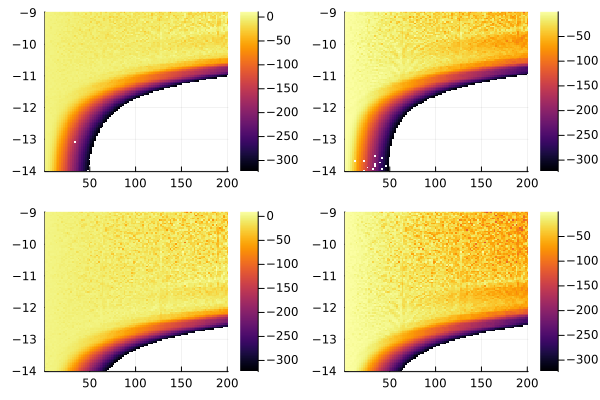

In [52]:
topleft = heatmap(
    binss,
    logdm2s,
    log10.(submatdets[1])
)
topright = heatmap(
    binss,
    logdm2s,
    log10.(submatdets[2])
)
bottomright = heatmap(
    binss,
    logdm2s,
    log10.(submatdets[3])
)
bottomleft = heatmap(
    binss,
    logdm2s,
    log10.(submatdets[4])
)

plot(topleft, topright, bottomright, bottomleft, layout=(2,2))

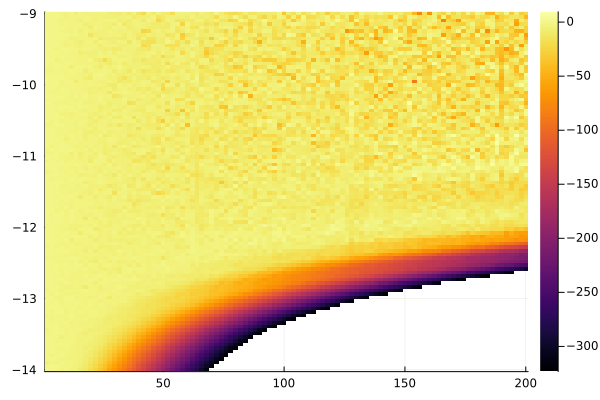

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [62]:
bottomright

In [153]:
# Spatial PDF calculation functions

# The true PDF
function pdtrue(dm2, l, b, bins)

    rbins = range(0, 30, bins)

    pds = probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b))

end

# The reconstruction going off of the approximate binned event distribution, with the pseudoinverse matrix algorithm
function pdreconstruct(dm2, l, b, bins)

    mat = matrixA(dm2, l, b, bins)

    eventsvec = perfectedistapprox(dm2, l, b, 0.005, bins)

    sol = pinv(mat) * eventsvec

end

# Calculating the accuracy of the above reconstruction
function recoaccuracy(dm2, bins, l, b)

    truepd = pdtrue(dm2, l, b, bins)

    recpd = pdreconstruct(dm2, l, b, bins)

    # acc = norm((recpd .- truepd) ./ truepd)
    accvec = norm(recpd .- truepd) / norm(truepd)

end

# Unmodified algorithm for the reconstruction accounting for the correct perfect edist
# Very incorrect
function pdreconstruct1(dm2, l, b, bins)

    mat = matrixA(dm2, l, b, bins)

    eventsvec = perfectedist(dm2, l, b, 0.005, bins)

    sol = pinv(mat) * eventsvec

end

# Reconstruction accounting for the correct perfect edist, CORRECT (I think) minimization algorithm with
# initial value left free
function pdreconstructapprox(dm2, l, b, bins, ival)

    pdperfect = perfectedist(dm2, l, b, 0.005, bins)

    # Map from R^bins to R, so should have a gradient
    function approx1(solapprox)
        solapprx = vec(solapprox)
        A = matrixA(dm2, l, b, bins)
        output = norm((A * solapprx) - pdperfect)
    end

    x0 = zeros(1, bins) .+ ival
    optim = optimize(approx1, x0)
    params = Optim.minimizer(optim)
    return vec(params)
end

function pdreconstructapprox_grad(dm2, l, b, bins, ival)

    pdperfect = perfectedist(dm2, l, b, 0.005, bins)

    # Map from R^bins to R, so should have a gradient
    function approx1(solapprox)
        solapprx = vec(solapprox)
        A = matrixA(dm2, l, b, bins)
        # Squaring the function for easier computation
        output = (norm((A * solapprx) - pdperfect))^2
    end

    # Test gradient
    function g!(G, solapprox)
        solapprx = vec(solapprox)
        A = matrixA(dm2, l, b, bins)
        innervec = (A * solapprx) - pdperfect
        for i in 1:bins
            G[i] = 2*dot(A[:, i], innervec)
        end
        # G = [2*dot(A[:, i], innervec) for i in 1:bins]
    end

    x0 = zeros(1, bins) .+ ival
    optim = optimize(approx1, g!, x0, LBFGS())
    params = Optim.minimizer(optim)
    return vec(params)
end

function pdreconstructapprox_constrained(dm2, l, b, bins, ival)

    pdperfect = perfectedist(dm2, l, b, 0.005, bins)

    # Map from R^bins to R, so should have a gradient
    function approx1(solapprox)
        solapprx = vec(solapprox)
        A = matrixA(dm2, l, b, bins)
        # Squaring the function for easier computation
        output = (norm((A * solapprx) - pdperfect))^2
    end

    # Test gradient
    function g!(G, solapprox)
        solapprx = vec(solapprox)
        A = matrixA(dm2, l, b, bins)
        innervec = (A * solapprx) - pdperfect
        for i in 1:bins
            G[i] = 2*dot(A[:, i], innervec)
        end
        # G = [2*dot(A[:, i], innervec) for i in 1:bins]
    end

    x0 = zeros(1, bins) .+ ival
    # Setting bounds
    lower = zeros(1, bins)
    upper = zeros(1, bins) .+ 0.01
    optim = optimize(approx1, g!, lower, upper, x0, Fminbox(GradientDescent()))
    params = Optim.minimizer(optim)
    return vec(params)
end



pdreconstructapprox_constrained (generic function with 1 method)

In [154]:
recovec_grad = pdreconstructapprox(10^(-14), 0, 0, 10, 0.003)
# recovec_nograd = pdreconstructapprox(10^(-14), 0, 0, 50, 0.003)

10-element Vector{Float64}:
  0.02014584862860312
  0.01814086236998472
 -0.009363434796108383
  0.00605600594167982
 -0.004186866579660039
  0.008618918268752308
  0.00898252772649223
 -0.01270801083650803
 -0.00045613512378827546
  0.004119174978171604

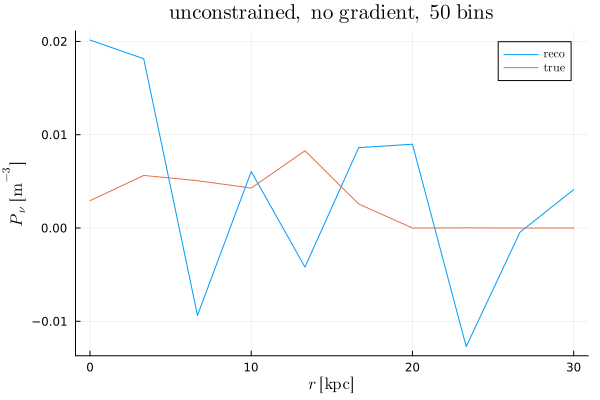

In [155]:
plot(
    range(0, 30, 10),
    [recovec_grad pdtrue(10^(-14), 0, 0, 10)],
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    label=[L"\mathrm{reco}" L"\mathrm{true}"],
    title=L"\mathrm{unconstrained,~no~gradient,~50~bins}"
)

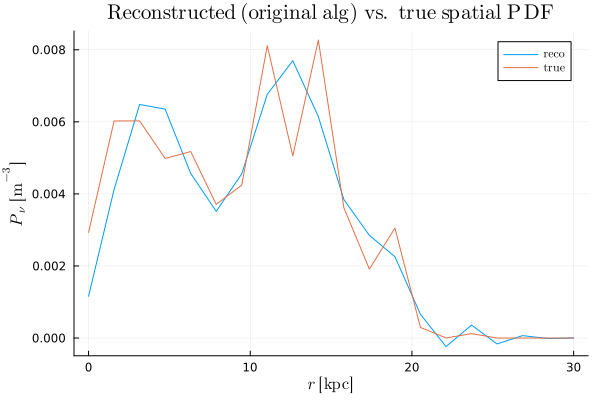

In [21]:
# Plotting the original reconstruction vs. the true PDF

nbins = 20

rbins = range(0, 30, nbins)

plot(
    rbins,
    [pdreconstruct(10^(-14), 0, 0, nbins) pdtrue(10^(-14), 0, 0, nbins)],
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    label=[L"\mathrm{reco}" L"\mathrm{true}"],
    title=L"\mathrm{Reconstructed~(original~alg)~vs.~true~spatial~PDF}",
)


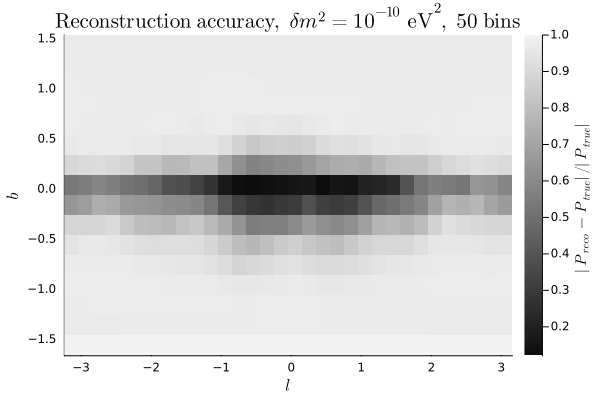

In [19]:
# Plotting accuracies of the original reconstruction algorithm

ls = -π:0.2:π
bs = (-π/2):0.2:(π/2)

testmat = [recoaccuracy(10^(-10), 50, l, b) for b in bs, l in ls]

heatmap(
    ls,
    bs,
    testmat,
    c=:grays,
    colorbar_title=L"|P_{reco} - P_{true}| / |P_{true}|",
    title=L"\mathrm{Reconstruction~accuracy},~\delta m^2 = 10^{-10}~\mathrm{eV}^2,~50~\mathrm{bins}",
    xlabel=L"l",
    ylabel=L"b"
)


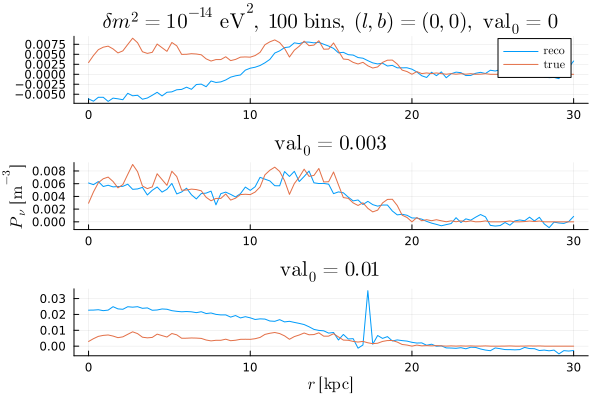

In [690]:
# New reco algorithm with varying the initial vector that's minimized

bins = 100; dm2 = 10^(-14.0)

rbins = range(0, 30, bins)

plot0 = plot(
    rbins,
    [pdreconstructapprox(dm2, 0, 0, bins, 0) pdtrue(dm2, 0, 0, bins)],
    # xlabel=L"r~[\mathrm{kpc}]",
    # ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    label=[L"\mathrm{reco}" L"\mathrm{true}"],
    title=L"\delta m^2 = 10^{-14}~\mathrm{eV}^2,~100~\mathrm{bins},~(l, b) = (0, 0),~\mathrm{val}_0 = 0"
)

plot1 = plot(
    rbins,
    [pdreconstructapprox(dm2, 0, 0, bins, 0.003) pdtrue(dm2, 0, 0, bins)],
    # xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    # label=[L"\mathrm{reco}" L"\mathrm{true}"],
    label=false,
    title=L"\mathrm{val}_0 = 0.003"
)

plot3 = plot(
    rbins,
    [pdreconstructapprox(dm2,0, 0, bins, 0.01) pdtrue(dm2, 0, 0, bins)],
    xlabel=L"r~[\mathrm{kpc}]",
    # ylabel=L"P_{\nu}~[\mathrm{m}^{-3}]",
    # label=[L"\mathrm{reco}" L"\mathrm{true}"],
    label=false,
    title=L"\mathrm{val}_0 = 0.01"
)

plot(plot0, plot1, plot3, layout=(3,1))

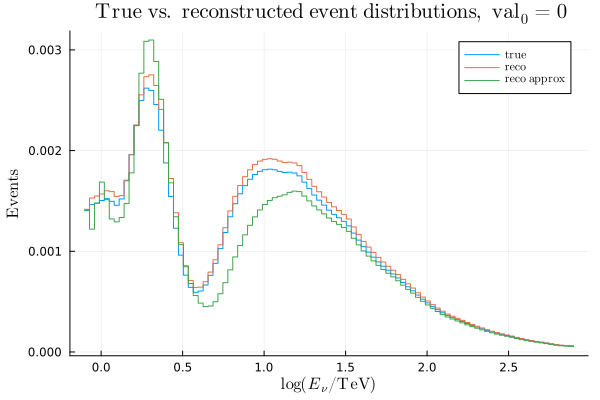

In [23]:
# Plotting the event distributions that result from different PDF reconstruction algs

bins = 100; dm2 = 10^(-14)

ebins = range(log10(emin), log10(emax), bins)

recoedistapprox = matrixA(dm2, 0, 0, bins) * pdreconstructapprox(dm2, 0, 0, bins, 0.0)
recoedist = matrixA(dm2, 0, 0, bins) * pdreconstruct(dm2, 0, 0, bins)

plot(
    ebins,
    [perfectedist(dm2, 0, 0, 0.005, bins) recoedist recoedistapprox],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{true}" L"\mathrm{reco}" L"\mathrm{reco~approx}"],
    title=L"\mathrm{~True~vs.~reconstructed~event~distributions},~\mathrm{val}_0 = 0"
)

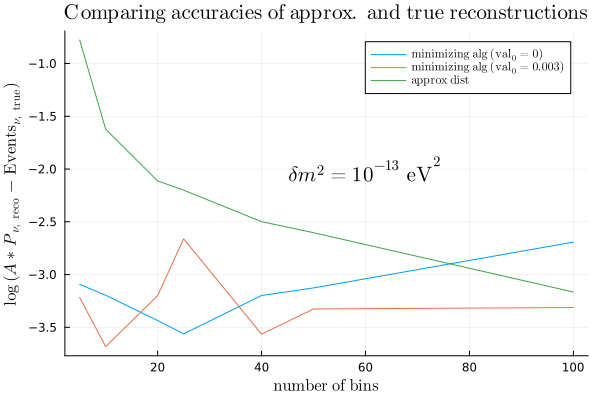

In [41]:
# Plotting the difference between the accuracies of different reconstructions algorithms as a function of bin number

dm2 = 10^(-13)
binss = [5, 10, 20, 25, 40, 50, 100]

accs = [norm(matrixA(dm2, 0, 0, bins) * pdreconstruct(dm2, 0, 0, bins) .- perfectedist(dm2, 0, 0, 0.005, bins)) for bins in binss]
accsapprox0 = [norm(matrixA(dm2, 0, 0, bins) * pdreconstructapprox(dm2, 0, 0, bins, 0) .- perfectedist(dm2, 0, 0, 0.005, bins)) for bins in binss]
accsapprox3 = [norm(matrixA(dm2, 0, 0, bins) * pdreconstructapprox(dm2, 0, 0, bins, 0.003) .- perfectedist(dm2, 0, 0, 0.005, bins)) for bins in binss]

plot(
    binss,
    [log10.(accsapprox) log10.(accsapprox3) log10.(accs)],
    xlabel=L"\mathrm{number~of~bins}",
    ylabel=L"\log~(A * P_{\nu,~\mathrm{reco}} - \mathrm{Events}_{\nu,~\mathrm{true}})",
    label=[L"\mathrm{minimizing~alg}~(\mathrm{val}_0 = 0)" L"\mathrm{minimizing~alg}~(\mathrm{val}_0 = 0.003)" L"\mathrm{approx~dist}"],
    title=L"\mathrm{Comparing~accuracies~of~approx.~and~true~reconstructions}",
    ann=[(60, -2, L"\delta m^2 = 10^{-13}~\mathrm{eV}^2")]
)

In [13]:
dm2 = 10^(-14)
bins = 100
val0s = range(0, 0.005, 20)
l  = π; b = 0

accs = [norm(matrixA(dm2, l, b, bins) * pdreconstructapprox(dm2, l, b, bins, val0) .- perfectedist(dm2, l, b, 0.005, bins)) for val0 in val0s]

20-element Vector{Float64}:
 1.6127541241716623e-5
 0.0003205571422012288
 0.0003905357988087615
 0.0005545238740329563
 0.000696386676259623
 0.0008476998112025052
 0.0009952368004722838
 0.0014104834254544715
 0.0015497687950463653
 0.0019423564518583581
 0.0020642978010431794
 0.002335137992656921
 0.0025473202803134106
 0.0026020332616344733
 0.0030323734592368947
 0.003661802065632739
 0.004188577772070715
 0.004413122745495012
 0.005116899224248163
 0.005713096372204489

In [14]:
writedlm("misc_data/pd_rec0_accs_diff_val0_vals_anti_GC_bin.txt", accs)

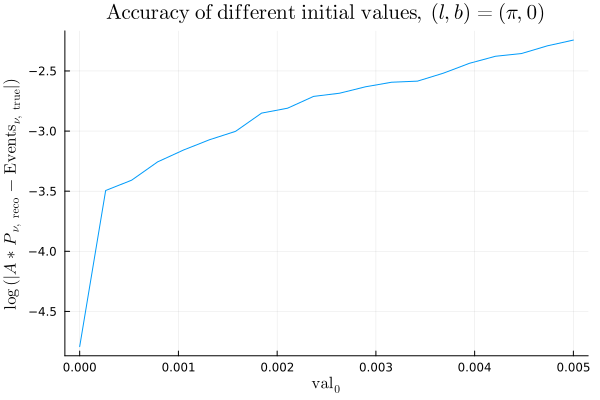

In [156]:
plot(
    val0s,
    log10.(accs),
    xlabel=L"\mathrm{val}_0",
    ylabel=L"\log~(\| A * P_{\nu,~\mathrm{reco}} - \mathrm{Events}_{\nu,~\mathrm{true}}\|)",
    label=false,
    title=L"\mathrm{Accuracy~of~different~initial~values},~(l, b) = (\pi, 0)"
)

In [19]:
Amat = [1 2; 3 4]
Amat[:, 1]

2-element Vector{Int64}:
 1
 3